In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import geopandas as gpd
from shapely.geometry import LineString

In [3]:
OUTPUT_DIR = Path("output")
tlc_path = OUTPUT_DIR / "OD_demand_TLC_nonneighbors.csv"
lodes_path = OUTPUT_DIR / "OD_demand_LODES_nonneighbors.csv"
df_tlc = pd.read_csv(tlc_path)
df_lodes = pd.read_csv(lodes_path)

print(f"TLC rows: {len(df_tlc):,}")
print(f"LODES rows: {len(df_lodes):,}")

TLC rows: 4,684,215
LODES rows: 1,787,819


In [4]:
df_tlc["total_trips"] = pd.to_numeric(df_tlc["total_trips"], errors="coerce")
df_lodes["total_commuters_2020_2022"] = pd.to_numeric(df_lodes["total_commuters_2020_2022"], errors="coerce")

# Standardize column names for consistency
df_tlc.rename(columns={"pickup_tract_id": "origin_tract", "dropoff_tract_id": "destination_tract"}, inplace=True)

df_tlc.head(), df_lodes.head()

(   origin_tract  destination_tract  total_trips
 0       4071600            1011900  102169.8087
 1       4071600            1012500  100254.4444
 2       4071600            1013100  100208.7469
 3       4071600            4033100   95493.7983
 4       4033100            1011900   86679.2597,
    origin_tract  destination_tract  total_commuters_2020_2022
 0       1025500            1020300                        756
 1       1014700            1008000                        695
 2       1012400            1025100                        609
 3       1005200            1010100                        604
 4       1025300            1020300                        544)

In [5]:
# --- TLC Demand Summary ---
print("TLC Demand Summary")
print(df_tlc["total_trips"].describe())

# --- LODES Demand Summary ---
print("\nLODES Commuter Summary")
print(df_lodes["total_commuters_2020_2022"].describe())

# --- Compare max scale difference ---
ratio = df_tlc["total_trips"].max() / df_lodes["total_commuters_2020_2022"].max()
print(f"\nScale Ratio (TLC max / LODES max): {ratio:,.1f}x")

TLC Demand Summary
count    4.684215e+06
mean     1.348609e+01
std      2.796732e+02
min      1.000000e-04
25%      2.460000e-02
50%      8.480000e-02
75%      3.339000e-01
max      1.021698e+05
Name: total_trips, dtype: float64

LODES Commuter Summary
count    1.787819e+06
mean     4.618946e+00
std      1.074437e+01
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      7.560000e+02
Name: total_commuters_2020_2022, dtype: float64

Scale Ratio (TLC max / LODES max): 135.1x


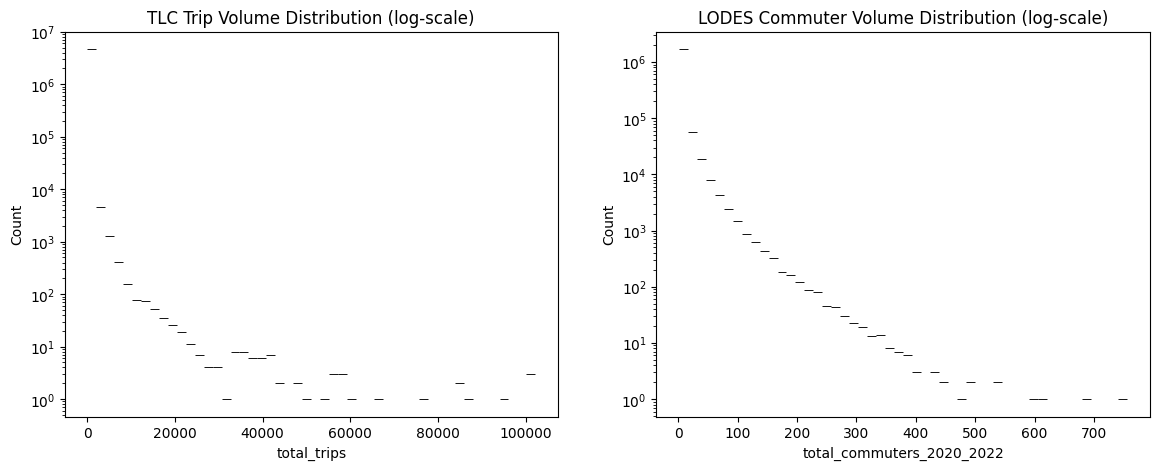

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.histplot(df_tlc["total_trips"], bins=50, ax=axes[0], log_scale=(False, True))
axes[0].set_title("TLC Trip Volume Distribution (log-scale)")

sns.histplot(df_lodes["total_commuters_2020_2022"], bins=50, ax=axes[1], log_scale=(False, True), color='orange')
axes[1].set_title("LODES Commuter Volume Distribution (log-scale)")

plt.show()

In [7]:
# Normalize to [0,1] scale for fair comparison
df_tlc["norm_trips"] = df_tlc["total_trips"] / df_tlc["total_trips"].max()
df_lodes["norm_commuters"] = df_lodes["total_commuters_2020_2022"] / df_lodes["total_commuters_2020_2022"].max()

print("Normalized TLC and LODES sample:")
display(df_tlc.head(), df_lodes.head())

Normalized TLC and LODES sample:


,origin_tract,destination_tract,total_trips,norm_trips
0,4071600,1011900,102169.8087,1.000000
1,4071600,1012500,100254.4444,0.981253
2,4071600,1013100,100208.7469,0.980806
3,4071600,4033100,95493.7983,0.934658
4,4033100,1011900,86679.2597,0.848384


,origin_tract,destination_tract,total_commuters_2020_2022,norm_commuters
0,1025500,1020300,756,1.000000
1,1014700,1008000,695,0.919312
2,1012400,1025100,609,0.805556
3,1005200,1010100,604,0.798942
4,1025300,1020300,544,0.719577


In [9]:
# Merge at OD-level
combined = pd.merge(
    df_tlc[["origin_tract", "destination_tract", "norm_trips"]],
    df_lodes[["origin_tract", "destination_tract", "norm_commuters"]],
    on=["origin_tract", "destination_tract"], how="outer"
).fillna(0)

# Equal weighting (50/50 baseline)
combined["universal_demand"] = 0.5 * combined["norm_trips"] + 0.5 * combined["norm_commuters"]

print(f"Combined Universal Demand Map created: {len(combined):,} rows")
combined.head()

Combined Universal Demand Map created: 4,859,146 rows


,origin_tract,destination_tract,norm_trips,norm_commuters,universal_demand
0,1000100,1000700,0.0,0.003968,0.001984
1,1000100,1000900,0.0,0.006614,0.003307
2,1000100,1001501,0.0,0.001323,0.000661
3,1000100,1001502,0.0,0.003968,0.001984
4,1000100,1001600,0.0,0.001323,0.000661


In [10]:
universal_path = OUTPUT_DIR / "Universal_Demand_Map.csv"
combined.to_csv(universal_path, index=False)
print(f"Saved Universal Demand Map to: {universal_path}")

Saved Universal Demand Map to: output/Universal_Demand_Map.csv


OD Pair Overlap Summary
Total OD pairs: 4,859,146
Shared by both datasets: 1,612,888 (33.19%)
Unique to TLC: 3,071,327 (63.21%)
Unique to LODES: 174,931 (3.60%)


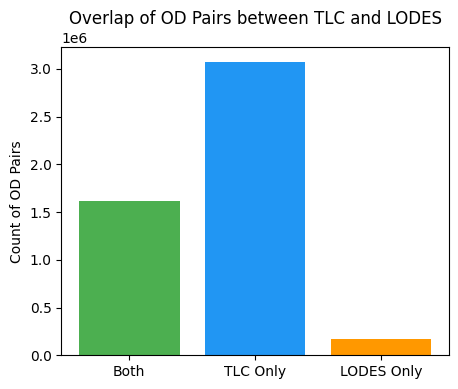

In [19]:
# Determine which dataset contributed each OD pair
has_tlc   = combined["norm_trips"] > 0
has_lodes = combined["norm_commuters"] > 0

# Overlap categories
both_mask   = has_tlc & has_lodes
tlc_only    = has_tlc & ~has_lodes
lodes_only  = ~has_tlc & has_lodes

# Counts
n_both  = both_mask.sum()
n_tlc   = tlc_only.sum()
n_lodes = lodes_only.sum()
n_total = len(combined)

print("OD Pair Overlap Summary")
print(f"Total OD pairs: {n_total:,}")
print(f"Shared by both datasets: {n_both:,} ({n_both/n_total*100:.2f}%)")
print(f"Unique to TLC: {n_tlc:,} ({n_tlc/n_total*100:.2f}%)")
print(f"Unique to LODES: {n_lodes:,} ({n_lodes/n_total*100:.2f}%)")


plt.figure(figsize=(5,4))
plt.bar(["Both","TLC Only","LODES Only"], [n_both,n_tlc,n_lodes], color=["#4caf50","#2196f3","#ff9800"])
plt.title("Overlap of OD Pairs between TLC and LODES")
plt.ylabel("Count of OD Pairs")
plt.show()


Demand Contribution Among Shared OD Pairs
Total shared OD pairs: 1,612,888
Aggregate normalized TLC demand share: 4.25%
Aggregate normalized LODES demand share: 95.75%

Dominance by count (% of shared OD pairs):
dominant_source
LODES    98.99
TLC       1.01
Name: proportion, dtype: float64


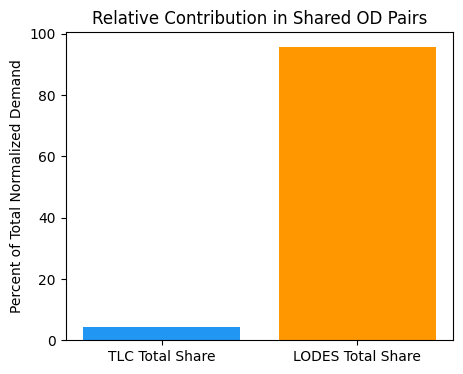

In [12]:
# Filter only shared pairs
shared_df = combined[(combined["norm_trips"] > 0) & (combined["norm_commuters"] > 0)].copy()

# Compare normalized magnitudes
shared_df["dominant_source"] = np.where(
    shared_df["norm_trips"] > shared_df["norm_commuters"], "TLC",
    np.where(shared_df["norm_trips"] < shared_df["norm_commuters"], "LODES", "Equal")
)

# Compute aggregate normalized demand totals
tlc_total = shared_df["norm_trips"].sum()
lodes_total = shared_df["norm_commuters"].sum()
total_shared_demand = tlc_total + lodes_total

tlc_share = tlc_total / total_shared_demand * 100
lodes_share = lodes_total / total_shared_demand * 100

# Count dominance
dominance_counts = shared_df["dominant_source"].value_counts(normalize=True) * 100

print("Demand Contribution Among Shared OD Pairs")
print(f"Total shared OD pairs: {len(shared_df):,}")
print(f"Aggregate normalized TLC demand share: {tlc_share:.2f}%")
print(f"Aggregate normalized LODES demand share: {lodes_share:.2f}%\n")

print("Dominance by count (% of shared OD pairs):")
print(dominance_counts.round(2))

plt.figure(figsize=(5,4))
plt.bar(["TLC Total Share","LODES Total Share"], [tlc_share,lodes_share],
        color=["#2196f3","#ff9800"])
plt.ylabel("Percent of Total Normalized Demand")
plt.title("Relative Contribution in Shared OD Pairs")
plt.show()


# Interpretation

- **Magnitude bias:** Taxi data has demand magnitudes up to 100,000 trips, while LODES caps at ~760.
  - After normalization, both datasets are comparable on a [0,1] scale.
- **Spatial bias:** TLC demand is concentrated around airports and Manhattan, while LODES reflects work-home commuter flows.


In [14]:
# Load census tracts shapefile
tracts_path = "nyc_tracts/nyct2020.shp"
gdf_tracts = gpd.read_file(tracts_path)

print("Columns in shapefile:", list(gdf_tracts.columns))

# Identify the column that holds the tract ID
tract_id_col_candidates = [c for c in gdf_tracts.columns if "TRACT" in c.upper() or "GEOID" in c.upper()]
tract_id_col = tract_id_col_candidates[0] if tract_id_col_candidates else None


print(f"Using '{tract_id_col}' as tract ID column.")

# Create a standardized ID and centroid
gdf_tracts["TRACT_ID"] = gdf_tracts[tract_id_col].astype(str).str.zfill(7)
gdf_tracts["centroid"] = gdf_tracts.geometry.centroid

# Create centroid lookup
centroid_lookup = gdf_tracts.set_index("TRACT_ID")["centroid"].to_dict()

print(f"Loaded {len(gdf_tracts)} tracts successfully.")

Columns in shapefile: ['CTLabel', 'BoroCode', 'BoroName', 'CT2020', 'BoroCT2020', 'CDEligibil', 'NTAName', 'NTA2020', 'CDTA2020', 'CDTANAME', 'GEOID', 'PUMA', 'Shape_Leng', 'Shape_Area', 'geometry']
Using 'GEOID' as tract ID column.
Loaded 2325 tracts successfully.


In [15]:
df_univ = combined.copy()

# Convert tract IDs to 7-digit strings
df_univ["origin_tract"] = df_univ["origin_tract"].astype(str).str.zfill(7)
df_univ["destination_tract"] = df_univ["destination_tract"].astype(str).str.zfill(7)

# Filter top flows
top_flows = df_univ.sort_values("universal_demand", ascending=False).head(500)
print(f"Top OD pairs selected: {len(top_flows)}")
top_flows.head()

Top OD pairs selected: 500


,origin_tract,destination_tract,norm_trips,norm_commuters,universal_demand
629509,1025500,1020300,0.001423,1.000000,0.500711
4290928,4071600,1011900,1.000000,0.001323,0.500661
4290934,4071600,1012500,0.981253,0.000000,0.490627
4290942,4071600,1013100,0.980806,0.000000,0.490403
4292529,4071600,4033100,0.934658,0.002646,0.468652


In [17]:
# Normalize tract ID formats so they align between shapefile and OD file
def normalize_geoid(val):
    s = str(val)
    if len(s) == 11 and s.startswith("36"):  # NYC GEOIDs
        return s[-7:]  # keep last 7 digits (Tract code)
    elif len(s) < 7:
        return s.zfill(7)
    else:
        return s

# Apply normalization to shapefile tract IDs
gdf_tracts["TRACT_ID"] = gdf_tracts[tract_id_col].apply(normalize_geoid)

# Create centroid dictionary again
gdf_tracts["centroid"] = gdf_tracts.geometry.centroid
centroid_lookup = gdf_tracts.set_index("TRACT_ID")["centroid"].to_dict()

print(f"Normalized tract IDs to 7-digit codes. Example:")
print(gdf_tracts[['TRACT_ID']].head())




flow_lines = []
missing_count = 0

for _, row in top_flows.iterrows():
    o, d, w = row["origin_tract"], row["destination_tract"], row["universal_demand"]
    if o in centroid_lookup and d in centroid_lookup:
        line = LineString([centroid_lookup[o], centroid_lookup[d]])
        flow_lines.append({
            "origin": o,
            "destination": d,
            "weight": w,
            "geometry": line
        })
    else:
        missing_count += 1

print(f"Created {len(flow_lines):,} line records. Skipped {missing_count:,} pairs missing tract centroids.")

# Explicitly tell GeoPandas which column is the geometry
gdf_flows = gpd.GeoDataFrame(flow_lines, geometry="geometry", crs=gdf_tracts.crs)
print(f"GeoDataFrame successfully created with {len(gdf_flows):,} flow lines.")

Normalized tract IDs to 7-digit codes. Example:
  TRACT_ID
0  1000100
1  1001401
2  1001402
3  1001800
4  1002201
Created 334 line records. Skipped 166 pairs missing tract centroids.
GeoDataFrame successfully created with 334 flow lines.


<Figure size 1000x1000 with 0 Axes>

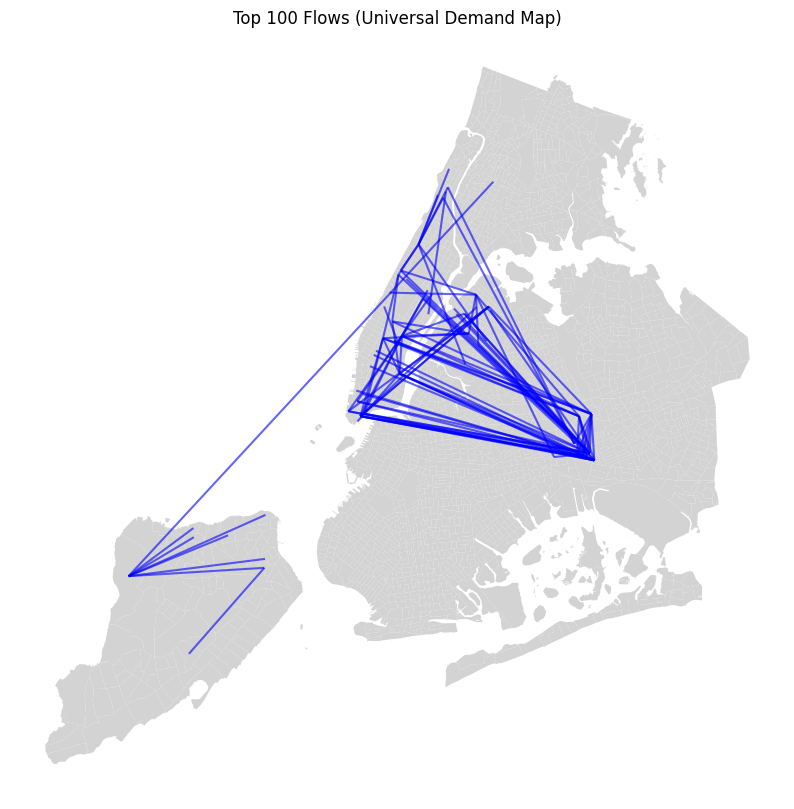

In [18]:
plt.figure(figsize=(10,10))
base = gdf_tracts.plot(color="lightgrey", linewidth=0.2, figsize=(10,10))
gdf_flows.sort_values("weight", ascending=False).head(100).plot(
    ax=base, linewidth=1.5, color="blue", alpha=0.6
)
plt.title("Top 100 Flows (Universal Demand Map)")
plt.axis("off")
plt.show()
